**Importing the dependencies**

In [7]:
import tensorflow as tf
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Dense,Activation,Dropout,Flatten,BatchNormalization
from keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

**Init Kaggle API**

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"<username>","key":"<password>"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d sagyamthapa/handwritten-math-symbols

100% 39.4M/39.4M [00:02<00:00, 22.0MB/s]
100% 39.4M/39.4M [00:02<00:00, 14.2MB/s]


In [ ]:
!unzip handwritten-math-symbols

**98% for the training and 2% for testing**

In [5]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255.,
                                  horizontal_flip = False,
                                  #Setting validation split to 2% 
                                  validation_split=0.02 
)

train_dir = "/content/dataset/"
IMAGE_SIZE = 50
BATCH_SIZE = 64

train_generator=train_datagen.flow_from_directory(
  train_dir,
  subset="training",
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  class_mode="categorical",
  color_mode="grayscale",
  batch_size=BATCH_SIZE
)

test_generator=train_datagen.flow_from_directory(
  train_dir,
  subset="validation",
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  class_mode="categorical",
  color_mode="grayscale",
  batch_size=BATCH_SIZE
)


Found 9880 images belonging to 19 classes.
Found 191 images belonging to 19 classes.


**Create the model**

In [8]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau


model = Sequential()
model.add(Conv2D(32,(3,3),input_shape =(IMAGE_SIZE,IMAGE_SIZE,1)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(19)) # output
model.add(Activation("softmax"))

model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 22, 22, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                  

**Train the model**

In [9]:

epochs = 10

checkpoint = ModelCheckpoint('model.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=test_generator, 
                    validation_steps=len(test_generator),
                    callbacks=[checkpoint])
     

Epoch 1/10
155/155 [==============================] - 25s 83ms/step - loss: 1.7372 - accuracy: 0.4767 - val_loss: 0.8233 - val_accuracy: 0.7696
Epoch 2/10
155/155 [==============================] - 12s 80ms/step - loss: 0.6866 - accuracy: 0.7934 - val_loss: 0.5515 - val_accuracy: 0.8482
Epoch 3/10
155/155 [==============================] - 12s 79ms/step - loss: 0.3892 - accuracy: 0.8814 - val_loss: 0.3490 - val_accuracy: 0.9005
Epoch 4/10
155/155 [==============================] - 12s 79ms/step - loss: 0.2677 - accuracy: 0.9170 - val_loss: 0.2792 - val_accuracy: 0.9162
Epoch 5/10
155/155 [==============================] - 12s 78ms/step - loss: 0.1912 - accuracy: 0.9436 - val_loss: 0.2085 - val_accuracy: 0.9319
Epoch 6/10
155/155 [==============================] - 12s 80ms/step - loss: 0.1465 - accuracy: 0.9515 - val_loss: 0.1991 - val_accuracy: 0.9424
Epoch 7/10
155/155 [==============================] - 12s 79ms/step - loss: 0.1085 - accuracy: 0.9660 - val_loss: 0.1680 - val_accuracy:

**Show the scores**

<ipython-input-10-94303580dc78>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


155/155 [==============================] - 12s 76ms/step - loss: 0.0254 - accuracy: 0.9927
Accuracy: 99.27%
Loss:  0.02540498971939087
3/3 [==============================] - 0s 65ms/step - loss: 0.2443 - accuracy: 0.9424
Accuracy: 94.24%
Loss:  0.24426110088825226


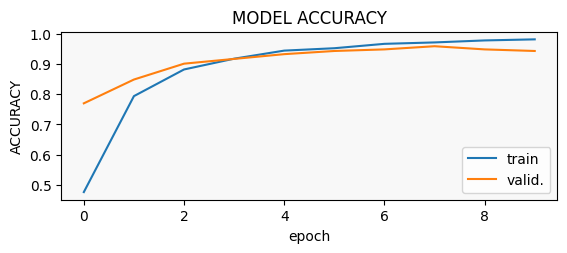

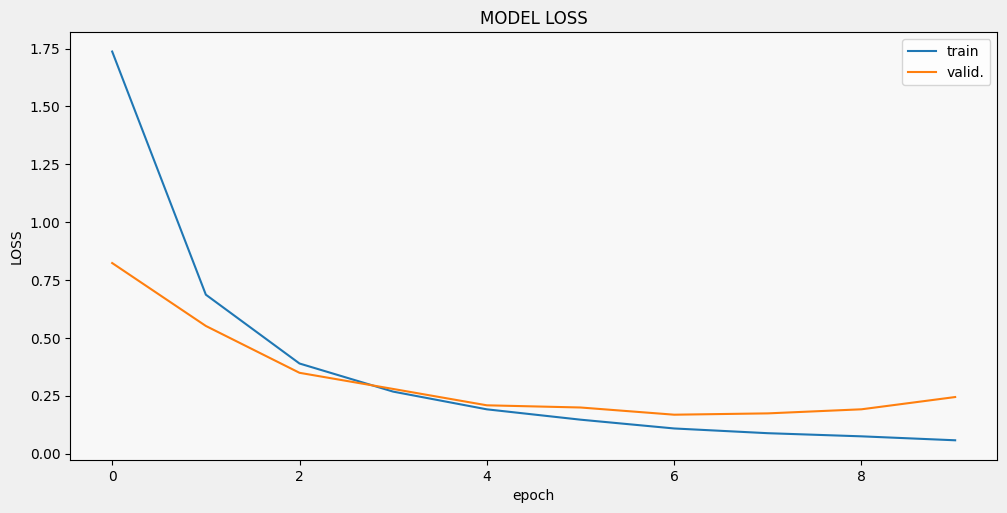

In [10]:
import matplotlib.pyplot as plt

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('MODEL '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'ACCURACY',
    212,
)
    

display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'LOSS',
    211,
)  

score = model.evaluate(train_generator,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

score = model.evaluate(test_generator,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

**Save the model**

In [11]:
!rm -R '/content/model'
!mkdir '/content/model'
model.save('/content/model')

!zip -r model.zip /content/model

rm: cannot remove '/content/model': No such file or directory


  adding: content/model/ (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 89%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model/variables/variables.index (deflated 60%)
  adding: content/model/keras_metadata.pb (deflated 92%)
  adding: content/model/fingerprint.pb (stored 0%)


**Show labels**

In [12]:
class_names=train_generator.class_indices

labels={}
for key, value in class_names.items():
    labels[value]=key
labels

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'add',
 11: 'dec',
 12: 'div',
 13: 'eq',
 14: 'mul',
 15: 'sub',
 16: 'x',
 17: 'y',
 18: 'z'}

**Test the model with random images**

In [13]:
import urllib.request  
urllib.request.urlretrieve("https://jonathanweisberg.org/img/nn_from_scratch/output_13_0.png", "0.jpg")
urllib.request.urlretrieve("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT0_VqvfbesoyV1E911aEdwiS7Njkk9YpAxgA&usqp=CAU","7.png")
urllib.request.urlretrieve("https://dab1nmslvvntp.cloudfront.net/wp-content/uploads/2019/10/15713178995.png","5.png")

('5.png', <http.client.HTTPMessage at 0x7ff08d1c62b0>)

Original Dimensions :  (252, 255)
1/1 [==============================] - 0s 220ms/step
0


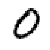

In [14]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow

reconstructed_model = tf.keras.models.load_model('/content/model/')

def GetResultForImage(image_location):
  img = cv2.imread(image_location, cv2.IMREAD_GRAYSCALE)
  print('Original Dimensions : ',img.shape)
  resized = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE),1)
  result = np.expand_dims(resized, axis=0)
  result=reconstructed_model.predict(result)
  print(labels[np.argmax(result)])
  cv2_imshow(resized)

GetResultForImage("0.jpg")

Original Dimensions :  (225, 225)
1/1 [==============================] - 0s 21ms/step
7


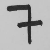

In [15]:
GetResultForImage("7.png")

Original Dimensions :  (510, 516)
1/1 [==============================] - 0s 36ms/step
5


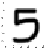

In [16]:
GetResultForImage("5.png")